# Model Evaluation

## Setup

In [1]:
from read_data import read_data

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
SEED = 42

## Import Data and Feature Engineering

In [3]:
train_df, test_df, test_labels_df = read_data("data/")

# ignore test values with -1 labels
test_df_usable = test_df.loc[test_labels_df['toxic'] != -1]
test_labels_df_usable = test_labels_df.loc[test_labels_df['toxic'] != -1]

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
# combine pre-selected train/test data
combined_X = pd.concat([train_df['comment_text'], test_df_usable['comment_text']])
combined_y = pd.concat([train_df[label_cols], test_labels_df_usable[label_cols]])

In [5]:
# # undersample comments with no positive labels
# neg_indices = combined_y[(combined_y == 0).all(axis=1)].index.tolist()
# pos_indices = combined_y[(combined_y != 0).any(axis=1)].index.tolist()

# np.random.seed(SEED)
# neg_indices = np.random.choice(neg_indices, len(pos_indices), replace=False)

# test_size = 0.2
# split_point = int(test_size * len(neg_indices))
# np.random.shuffle(neg_indices)
# np.random.shuffle(pos_indices)
# train_indices = np.concat([neg_indices[split_point:], pos_indices[split_point:]])
# test_indices = np.concat([neg_indices[:split_point], pos_indices[:split_point]])
# np.random.shuffle(train_indices)
# np.random.shuffle(test_indices)

# # establish train and test datasets
# train_X = combined_X.iloc[train_indices]
# test_X = combined_X.iloc[test_indices]
# train_y = combined_y.iloc[train_indices]
# test_y = combined_y.iloc[test_indices]

# print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

In [6]:
# establish train and test datasets
train_X, test_X, train_y, test_y = train_test_split(combined_X, combined_y, train_size=0.8, test_size=0.2, random_state=SEED)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(178839,) (44710,) (178839, 6) (44710, 6)


In [ ]:
# get TF-IDF features
tf_idf = TfidfVectorizer(encoding="utf-8", analyzer="word", ngram_range=(1,1), lowercase=True, stop_words="english")
train_X_tf = tf_idf.fit_transform(train_X)
test_X_tf = tf_idf.transform(test_X)
print(train_X_tf.shape, test_X_tf.shape)

(178839, 3216312) (44710, 3216312)


## Model Implementation

Chain order: insult, obscene, toxic, severe_toxic, identity_hate, threat  
(idx: 4, 2, 0, 1, 5, 3)

In [8]:
order = [4, 2, 0, 1, 5, 3]

# base = LogisticRegression(class_weight="balanced", C=1, tol=0.0001, max_iter=500, solver="lbfgs", random_state=SEED)
# base = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.1, gamma=0, min_child_weight=1, random_state=SEED)
base = RandomForestClassifier(n_estimators=1000, max_depth=16, class_weight="balanced", random_state=SEED)
chain = ClassifierChain(estimator=base, order=order, chain_method="predict_proba", random_state=SEED)

print("Model Parameters", "-" * 20, sep='\n')
for key, val in chain.get_params(deep=True).items():
    print(f"{key}: {val}")

chain.fit(train_X_tf, train_y)

pred = chain.predict(test_X_tf)
pred_proba = chain.predict_proba(test_X_tf)

Model Parameters
--------------------
base_estimator: deprecated
chain_method: predict_proba
cv: None
estimator__bootstrap: True
estimator__ccp_alpha: 0.0
estimator__class_weight: balanced
estimator__criterion: gini
estimator__max_depth: 16
estimator__max_features: sqrt
estimator__max_leaf_nodes: None
estimator__max_samples: None
estimator__min_impurity_decrease: 0.0
estimator__min_samples_leaf: 1
estimator__min_samples_split: 2
estimator__min_weight_fraction_leaf: 0.0
estimator__monotonic_cst: None
estimator__n_estimators: 1000
estimator__n_jobs: None
estimator__oob_score: False
estimator__random_state: 42
estimator__verbose: 0
estimator__warm_start: False
estimator: RandomForestClassifier(class_weight='balanced', max_depth=16, n_estimators=1000,
                       random_state=42)
order: [4, 2, 0, 1, 5, 3]
random_state: 42
verbose: False


## Metrics

In [9]:
print(f"Accuracy: {round(chain.score(test_X_tf, test_y), 4)}")
print(classification_report(y_true=test_y, y_pred=pred, target_names=[label_cols[idx] for idx in order], zero_division=np.nan))

Accuracy: 0.5728
               precision    recall  f1-score   support

       insult       0.20      0.89      0.33      4266
      obscene       0.02      0.98      0.05       384
        toxic       0.13      0.91      0.23      2486
 severe_toxic       0.01      0.93      0.02       133
identity_hate       0.12      0.92      0.21      2294
       threat       0.02      0.93      0.04       408

    micro avg       0.09      0.91      0.16      9971
    macro avg       0.08      0.93      0.15      9971
 weighted avg       0.15      0.91      0.25      9971
  samples avg       0.09      0.87      0.12      9971



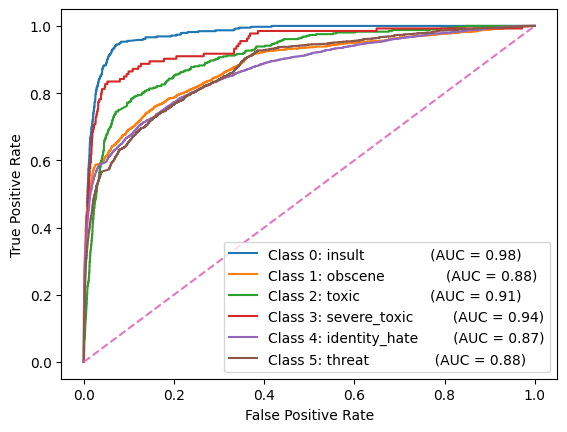

In [11]:
y_true_bin = label_binarize(test_y, classes=[label_cols[idx] for idx in order])

# Compute ROC curve and AUC for each class
for i in range(y_true_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_proba[:, i])
    roc_auc = roc_auc_score(y_true_bin[:, i], pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}: {label_cols[order[i]].ljust(20)} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()